### Описание задачи  
Разделение потребителей на группы может быть необходимо для разных целей, например для разработки правильной стратегии таргетинга, создания индивидуальных программ лояльности, выделения основных типов клиентов по типу потребительского поведения и т.п. RFM-сегментация является одной из наиболее распространенных стратегий для разделения клиентов по "лояльности" и подразумевает сегментацию по 3 признакам:
- recency - количество времени, прошедшего с момента последней покупки;
- frequency - число покупок, совершенных за все время;  
- monetary value - суммарное количество денег, потраченных клиентом за все время.  
  
### Описание датасета
- InvoiceNo - номер счета;  
- StockCode - код приобретенного товара;  
- Description - описание товара;  
- Quantity - количество приобретенного товара;  
- InvoiceData - дата совершения транзакции;  
- UnitPrice - цена одной единицы товара;  
- CustomerID - ID покупателя;  
- Country - страна проживания покупателя.  
  
### Содержание ноутбука  
  
Предварительная обработка данных включает в себя feature enjineering для RFM-сегментации, устранение пропусков и выбросов в данных, масштабирование и нормализацию. Далее подбирается наилучший параметр k для метода кластеризации k средних и дается трактовка сформированных кластеров.

In [110]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import pdist

import datetime

In [204]:
data = pd.read_excel('./online_retail.xlsx')

# Предварительная обработка

In [15]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Проверим наличие пропусков в данных

In [10]:
data.isnull().sum() 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

В столбце CustomerID достаточно много пропусков, и строки с пропусками придется удалить, поскольку невозможно использовать никакую другую характеристику для группировки покупателей. Для RFM-сегментации необходимо провести агрегацию покупок каждого клиента.

In [205]:
data1 = data.dropna(axis=0, how='any')

In [17]:
data1.shape

(406829, 8)

Также удалим ненужные для RFM-сегментации столбцы

In [206]:
data2 = data1.drop('StockCode', axis=1)
data2.drop('Description', axis=1, inplace = True)
data2.drop('Country', axis=1, inplace = True)

In [19]:
data2.shape

(406829, 5)

Посмотрим и на другие характеристики данных

In [21]:
data2.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
dtype: object

In [30]:
data2.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Строки с отрицательными значениями количества явно представляют собой аномалию и их нужно удалить

In [207]:
data2.drop(data2[data2['Quantity']<0].index, axis = 0, inplace = True)

In [41]:
data2.shape

(397924, 5)

Составим **RFM-таблицу** с помощью агрегации признаков

In [208]:
data3 = data2.copy()
data3["InvoiceDate"] = data3["InvoiceDate"].dt.date #не будем рассматривать время покупки, только день
data3["TotalSum"] = data3["Quantity"] * data3["UnitPrice"] #рассчитали стоимость покупки
last_date = max(data3['InvoiceDate']) + datetime.timedelta(days=1) #дата, после которой записей нет

In [209]:
customers = data3.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})

#recency вычисляется как разность между last_date и датой последней покупки,
#frequency - как общее число покупок, под покупкой подразумевается любое число приобретенных товаров в рамках одного чека
#monetary value - как суммарная стоимость всех покупок, сделанных когда-либо потребителем

customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'Monetary Value'}, inplace=True)

In [49]:
customers

,Recency,Frequency,Monetary Value
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


Визуализируем распределение новых признаков и нарисуем для них boxplot'ы

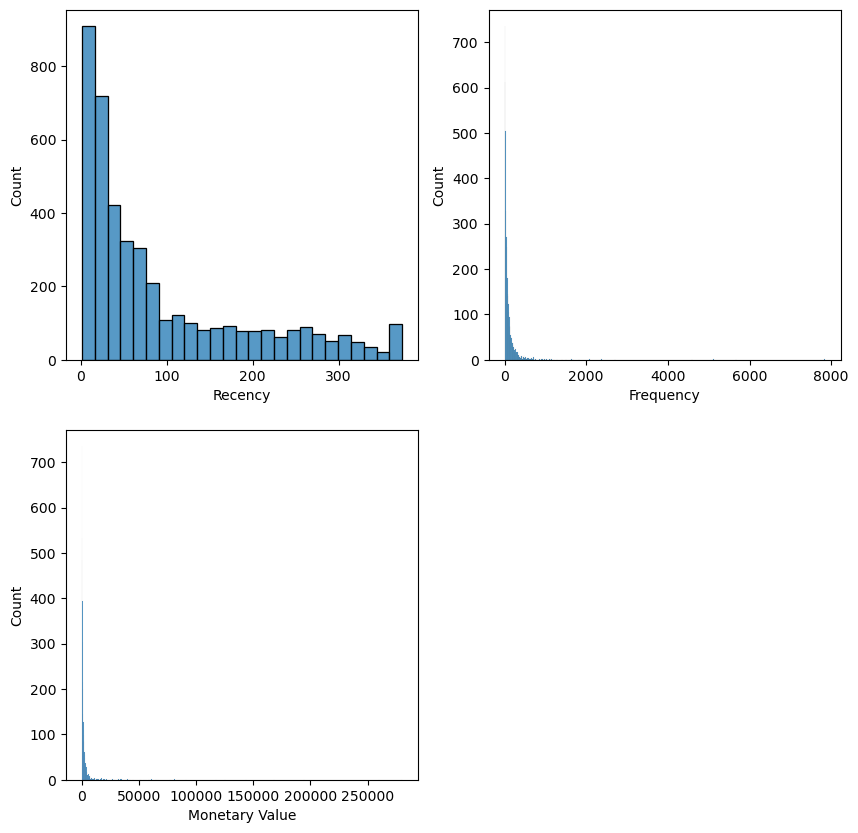

In [52]:
c_cols = ['Recency','Frequency','Monetary Value']
plt.figure(figsize = (10,10))
for i in range(len(c_cols)):
    plt.subplot(2,2,i+1)
    sns.histplot(customers[c_cols[i]])

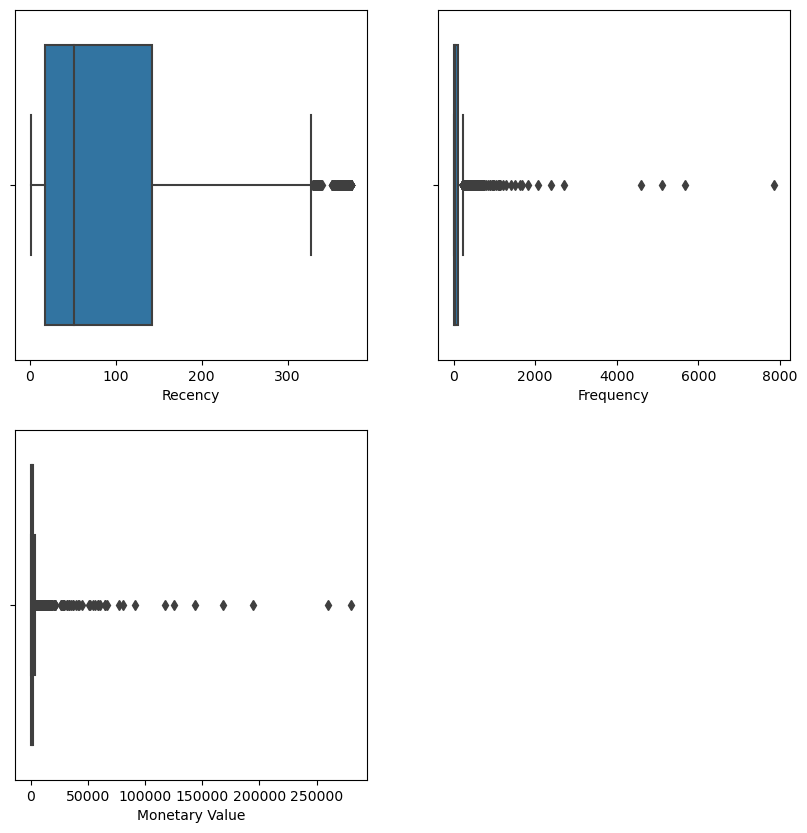

In [53]:
plt.figure(figsize = (10,10))

for i in range(len(c_cols)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=c_cols[i], data=customers)
    
plt.show()

Видно, что большая часть потребителей покупает не очень часто (Frequency) и не приносит много выручки (Monetary Value), но есть значительные выбросы. Выбросы определяются как значения, превышающие Q1-IQR и Q3+IQR, где Q1, Q3 - первый и третий квартили, IQR = Q3 - Q1 - межквартильный размах

In [210]:
Q1_1 = customers['Frequency'].quantile(q=.25)
Q3_1 = customers['Frequency'].quantile(q=.75)
IQR_1 = Q3_1-Q1_1
data_outliers_frequency = customers[(customers['Frequency'] < (Q1_1-1.5*IQR_1)) | (customers['Frequency'] > (Q3_1+1.5*IQR_1))]
print('Процент выбросов в Frequency равен', (data_outliers_frequency.shape[0]/customers.shape[0])*100)

Процент выбросов в Frequency равен 8.757778289928556


In [211]:
Q1_2 = customers['Monetary Value'].quantile(q=.25)
Q3_2 = customers['Monetary Value'].quantile(q=.75)
IQR_2 = Q3_2-Q1_2
data_outliers_monetary = customers[(customers['Monetary Value'] < (Q1_2-1.5*IQR_2)) | (customers['Monetary Value'] > (Q3_2+1.5*IQR_2))]
print('Процент выбросов в Monetary Value равен', (data_outliers_monetary.shape[0]/customers.shape[0])*100)

Процент выбросов в Monetary Value равен 9.840977183682877


Выбросы можно заменить на крайние значения Q1-IQR и Q3+IQR

In [212]:
new_customers = customers.copy()
def f_1(Frequency):
    if Frequency<(Q1_1-1.5*IQR_1):
        return Q1_1-1.5*IQR_1
    elif Frequency>(Q3_1+1.5*IQR_1):
        return Q3_1+1.5*IQR_1
    else:
        return Frequency
def f_2(Monetary_Value):
    if Monetary_Value<(Q1_2-1.5*IQR_2):
        return Q1_2-1.5*IQR_2
    elif Monetary_Value > (Q3_2+1.5*IQR_2):
        return Q3_2+1.5*IQR_2
    else:
        return Monetary_Value
customers_with_modified_outliers = customers['Frequency'].apply(f_1)
new_customers.drop('Frequency',axis=1,inplace=True)
new_customers['Frequency']=list(customers_with_modified_outliers)
customers_with_modified_outliers = customers['Monetary Value'].apply(f_2)
new_customers.drop('Monetary Value',axis=1,inplace=True)
new_customers['Monetary Value']=list(customers_with_modified_outliers)

Теперь распределения выглядят так

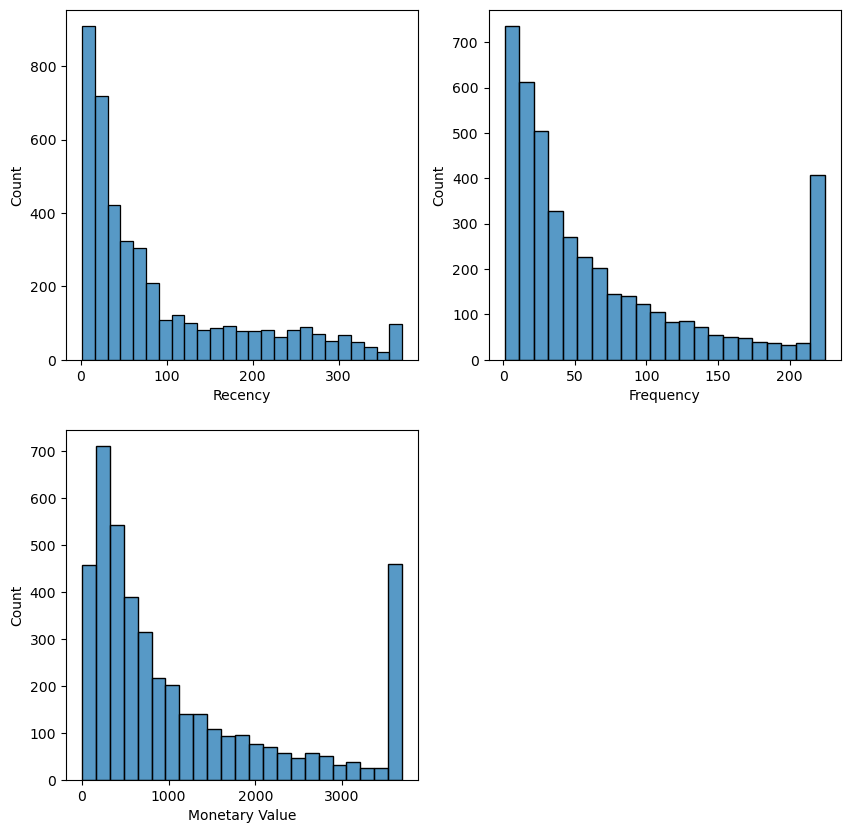

In [89]:
c_cols = ['Recency','Frequency','Monetary Value']
plt.figure(figsize = (10,10))
for i in range(len(c_cols)):
    plt.subplot(2,2,i+1)
    sns.histplot(new_customers[c_cols[i]])

In [96]:
new_customers.describe()

,Recency,Frequency,Monetary Value
count,4339.000000,4339.000000,4339.000000
mean,93.041484,69.020512,1162.644889
std,100.007757,68.685514,1148.076131
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.500000,100.000000,1661.640000
max,374.000000,224.500000,3693.232500


Проведем нормализацию данных

<IPython.core.display.Javascript object>


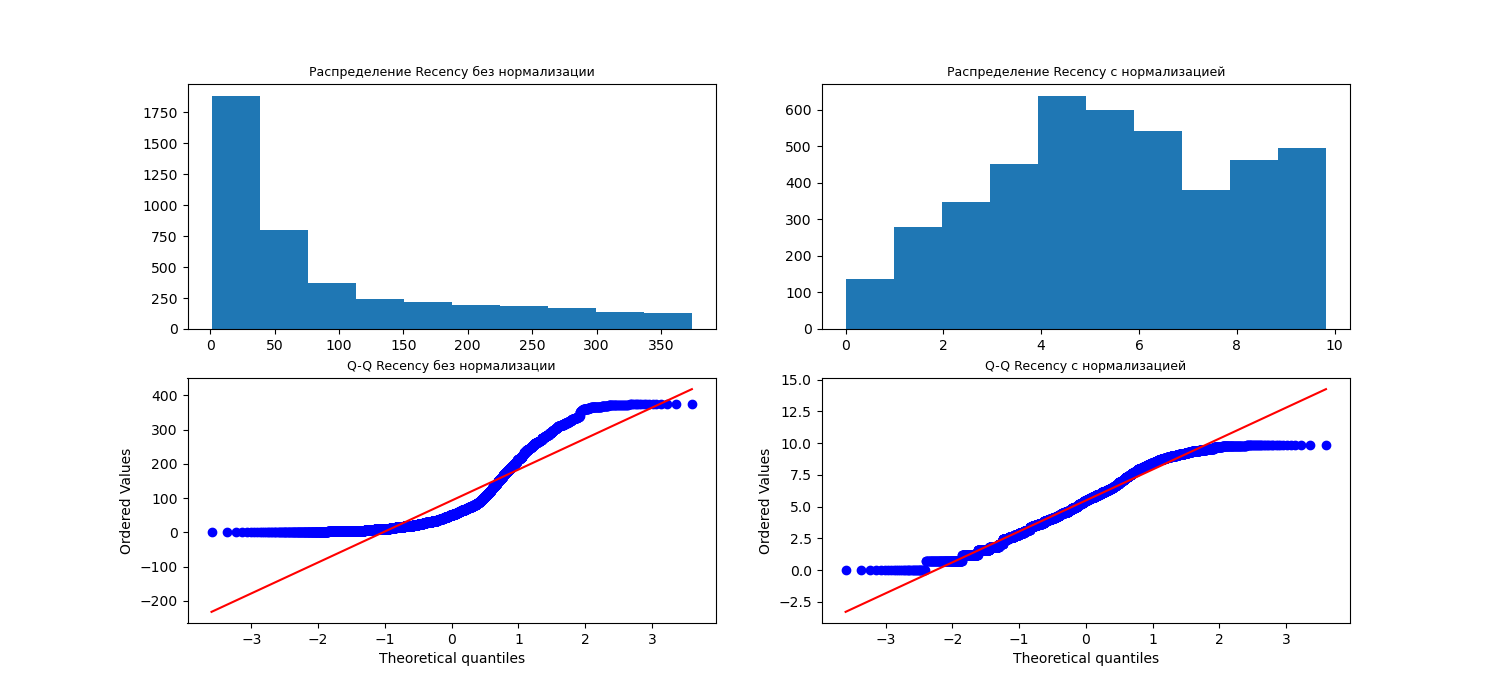

<IPython.core.display.Javascript object>


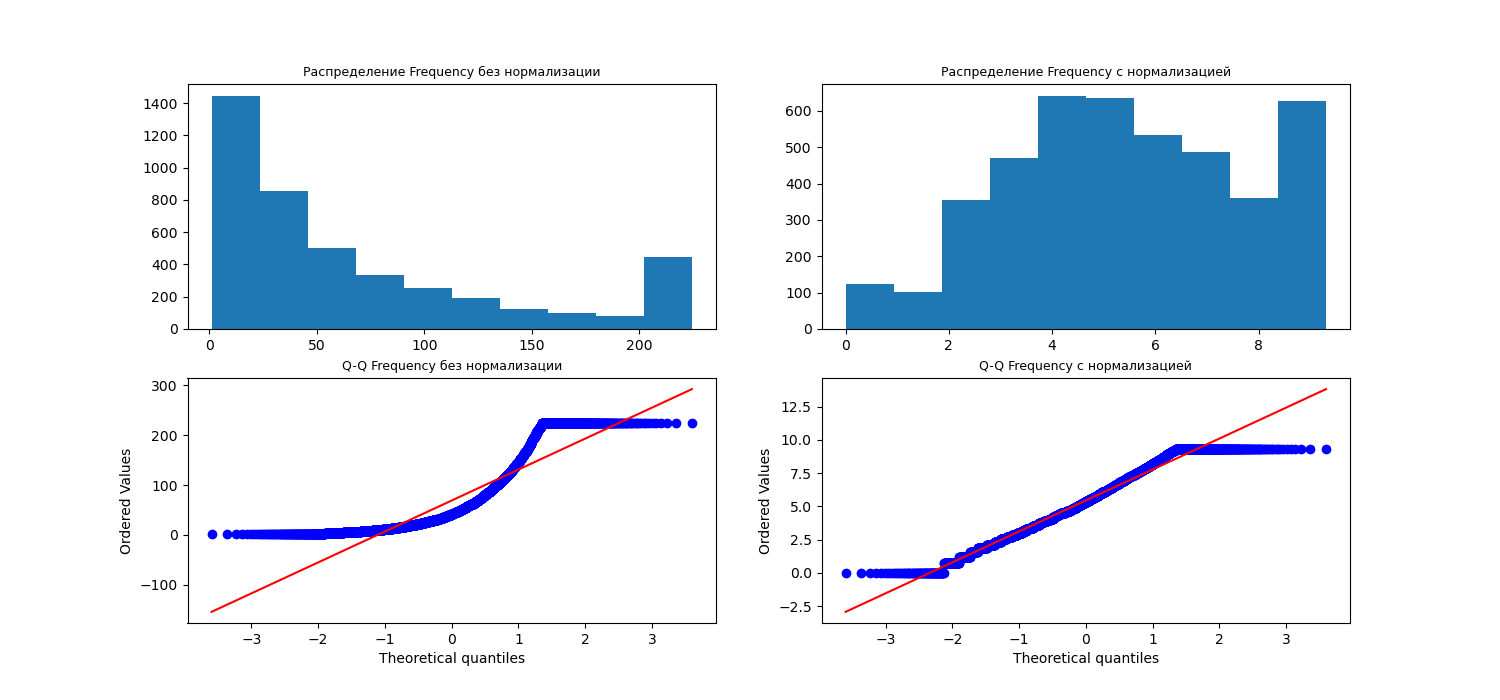

<IPython.core.display.Javascript object>


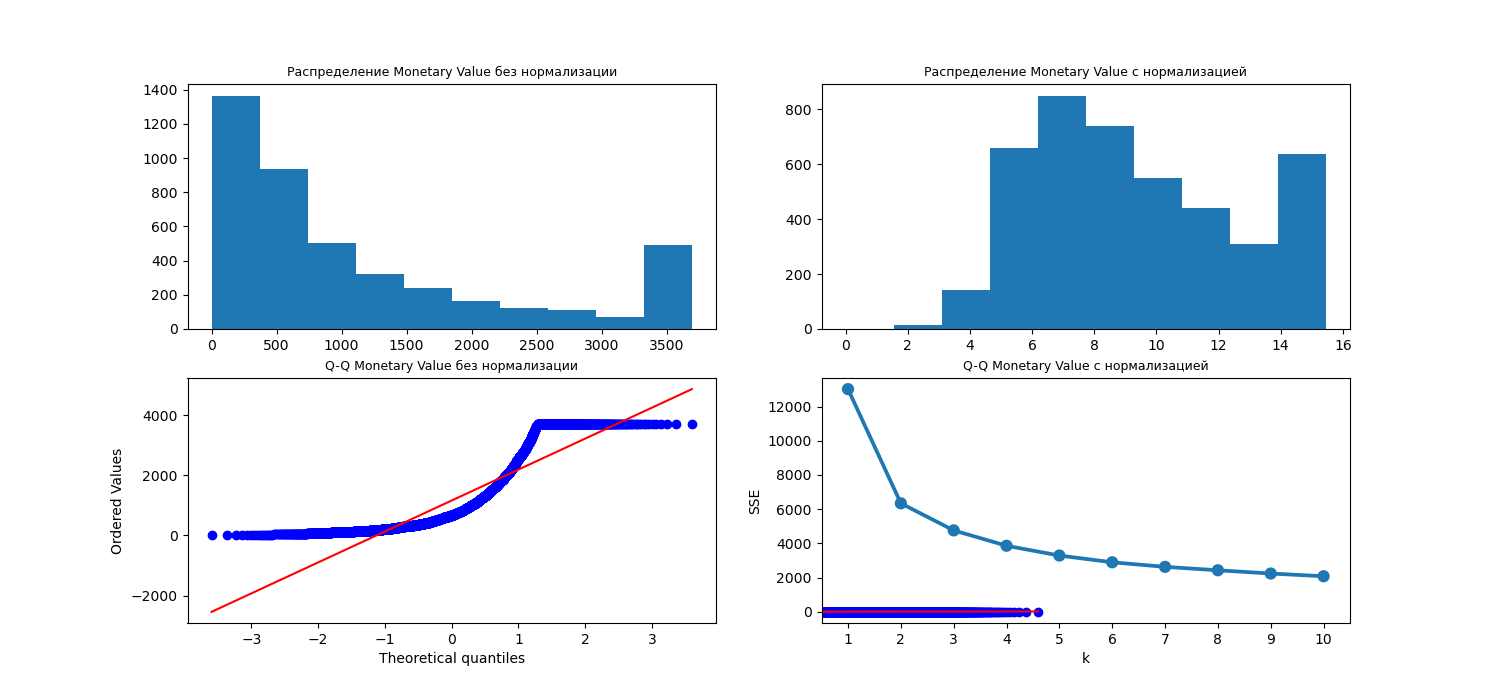

In [213]:
for col in ['Recency','Frequency']:
    plt.subplots(2,2,figsize=(15,7))
    
    plt.subplot(2,2,1)
    plt.hist(new_customers[col])
    plt.title('Распределение {} без нормализации'.format(col),fontsize=9)
    
    plt.subplot(2,2,2)
    plt.hist(stats.boxcox(new_customers[col])[0])
    plt.title('Распределение {} с нормализацией'.format(col),fontsize=9)
    
    plt.subplot(2,2,3)
    stats.probplot(new_customers[col], dist="norm", plot=plt)
    plt.title('Q-Q {} без нормализации'.format(col),fontsize=9)
    
    plt.subplot(2,2,4)
    stats.probplot(stats.boxcox(new_customers[col])[0], dist="norm", plot=plt)
    plt.title('Q-Q {} с нормализацией'.format(col),fontsize=9)
    
    plt.show()

plt.subplots(2,2,figsize=(15,7))
    
plt.subplot(2,2,1)
plt.hist(new_customers['Monetary Value'])
plt.title('Распределение Monetary Value без нормализации',fontsize=9)
    
plt.subplot(2,2,2)
plt.hist(np.cbrt(new_customers['Monetary Value']))
plt.title('Распределение Monetary Value с нормализацией',fontsize=9)
    
plt.subplot(2,2,3)
stats.probplot(new_customers['Monetary Value'], dist="norm", plot=plt)
plt.title('Q-Q Monetary Value без нормализации',fontsize=9)
    
plt.subplot(2,2,4)
stats.probplot(np.cbrt(new_customers['Monetary Value']), dist="norm", plot=plt)
plt.title('Q-Q Monetary Value с нормализацией',fontsize=9)
    
plt.show()

In [214]:
normalized_customers = new_customers.copy()
normalized_customers['Recency'] = stats.boxcox(new_customers['Recency'])[0]
normalized_customers['Frequency'] = stats.boxcox(new_customers['Frequency'])[0]
normalized_customers['Monetary Value'] = np.cbrt(new_customers['Monetary Value'])

Теперь отмасштабируем признаки

In [215]:
df = normalized_customers.copy()

In [216]:
for col in normalized_customers.columns:
    sc = StandardScaler()
    df[[col]]=list(sc.fit_transform(normalized_customers[[col]]))

In [217]:
df.describe()

,Recency,Frequency,Monetary Value
count,4.339000e+03,4.339000e+03,4.339000e+03
mean,1.020860e-16,-2.007306e-17,9.345678e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.225967e+00,-2.311739e+00,-2.788468e+00
25%,-7.380041e-01,-7.309619e-01,-7.845552e-01
50%,-1.149321e-02,-4.586385e-02,-1.841114e-01
75%,8.329102e-01,7.713884e-01,7.289946e-01
max,1.761319e+00,1.638545e+00,1.801955e+00


Обозначим X

In [218]:
X = df.values

# Алгоритм кластеризации "k средних"

Чтобы определить оптимальное количество кластеров, нарисуем так называемый elbow plot

In [219]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_

#Elbow Plot    
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [223]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_3.fit_predict(X)
silhouette = silhouette_score(X, clusters)
silhouette

0.33241075137952797

Видим, что метрика силуэта недостаточно высокая, но приемлемая, а при визуализации заметно, как вырисовываются кластеры

<IPython.core.display.Javascript object>


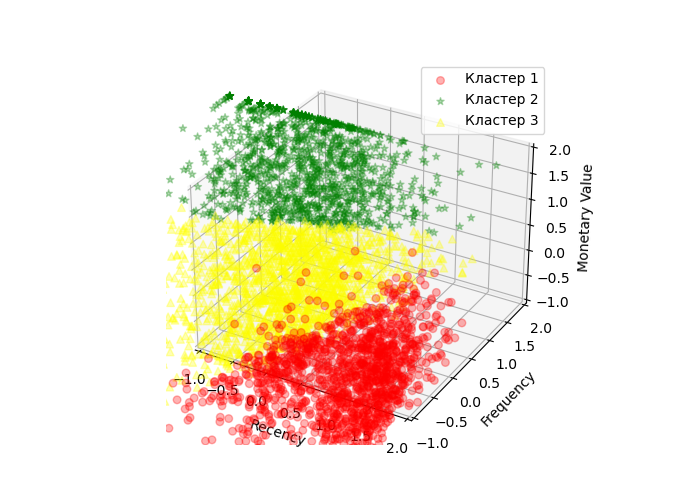

In [224]:
# %matplotlib notebook 

Xax = X[:,0]
Yax = X[:,1]
Zax = X[:,2]

cdict = {0:'red',1:'green',2:'yellow'}
labl = {0:'Кластер 1',1:'Кластер 2',2:'Кластер 3'}
marker = {0:'o',1:'*',2: '^'}
alpha = {0:.3, 1:.3, 2:.3}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(clusters):
 ix=np.where(clusters==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l],s=30,label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel("Recency", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
ax.set_zlabel("Monetary Value", fontsize=10)
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.set_zlim([-1, 2])

ax.legend()
plt.show()

Найдем средние значения Recency, Frequency и Monetary Value для разных кластеров.

In [225]:
df["Cluster"] = clusters
df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary Value':['mean', 'count']}).round(2)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0          0.98     -0.91          -0.84  1472
1         -0.78      1.16           1.27  1220
2         -0.30     -0.05          -0.19  1647

# Вывод

Таким образом, кластеры можно описать следующим образом:  
  
- Кластер 0 - клиенты, которые потратили меньше всего, реже всех совершали покупки, и последняя их покупка была сделана давно. Скорее всего, они совершили несколько недорогих покупок в прошлом и потом по какой-то причине перестали покупать товары в этом магазине. У этого кластера худшие показатели среди всех.  
    
    
    
- Кластер 1 - клиенты, которые потратили больше всех, приобретали товары чаще остальных и в последний раз делали покупки недавно. Видимо, это постоянные посетители магазина. У этого кластера лучшие показатели среди всех.
  
    
- Кластер 2 - клиенты со средними показателями относительно остальных кластеров. Покупателей в этом кластере больше, чем во всех остальных.